## GSE196728 - The human blood transcriptome exhibits time-of-day-dependent response to hypoxia: Lessons from the highest city in the world

- Sadly the dataset isn't complete. There are missing some altitude values.
- https://pubmed.ncbi.nlm.nih.gov/35977481/

In [ ]:
import COFE.analyse
import COFE.scpca
import COFE.plot
import numpy as np
import anndata as ad
import pandas as pd
import custom_func as pc
import matplotlib.pyplot as plt
from umap import UMAP
from pydeseq2.preprocessing import deseq2_norm

### Step 1: Open the dataset

In [3]:
path = '/Users/maksimsgolubovics/Python_VScode/Studienprojekt/rnaseq_datasets/GSE196728_rnaseq.h5ad'
adata = ad.read_h5ad(path)

#Transform to DataFrame
data_df = pd.DataFrame(data=adata.X, columns=adata.var.index, index=adata.obs.index).T

#Look at sampeles features
adata.var[['altitude', 'subject', 'time']]
adata.var['altitude'].unique()

data_df

GeneID,100287102,653635,102466751,107985730,100302278,645520,79501,100996442,729737,102725121,...,4538,4564,4575,4568,4540,4541,4556,4519,4576,4571
GSM5899659,28,90,0,0,0,0,0,9,1359,6,...,4211,9,4,1,834,1373,458,3250,7,3
GSM5899660,30,79,0,0,0,0,0,2,825,17,...,2323,2,0,0,679,1244,410,1555,6,10
GSM5899661,20,135,0,1,0,0,0,6,770,3,...,2027,1,0,2,595,1132,449,1301,4,8
GSM5899665,53,186,0,0,0,1,0,11,1523,19,...,19390,24,6,8,2788,5159,1576,13303,18,35
GSM5899666,22,92,0,0,0,0,0,9,1403,5,...,1480,1,1,2,402,552,214,1086,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM5899750,19,64,0,0,0,0,0,2,241,10,...,3187,6,0,6,676,1170,444,2291,3,2
GSM5899751,20,131,0,0,0,0,0,3,1338,3,...,2259,2,1,2,641,1830,748,1915,4,15
GSM5899752,9,66,0,0,0,0,0,6,655,1,...,2353,0,0,1,617,1336,457,1562,2,7
GSM5899758,35,152,0,0,0,0,0,4,918,14,...,7446,14,2,3,1337,2071,660,4359,2,4


The data do not appear to be complete. There should be 144 samples.

### Step 2: Prepare the dataset

In [10]:
data_df_norm = deseq2_norm(data_df)[0]
data_df_log = np.log10(data_df_norm + 0.1) #Logarithmic transformation

### Step 3: Exploratory analysis

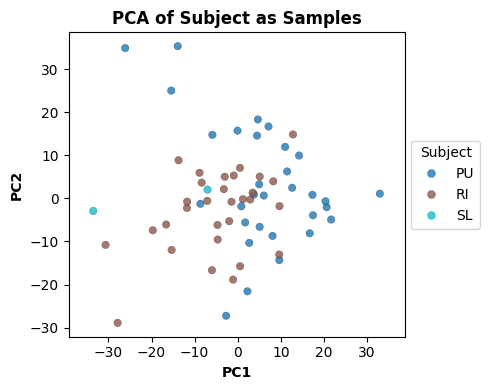

In [11]:
data_df_log_time = data_df_log.join(adata.var['altitude']).reset_index().set_index('altitude').drop('index', axis=1)
pc.principal_component_2d_timesample(data=data_df_log_time, label='Subject', c_map='tab10')

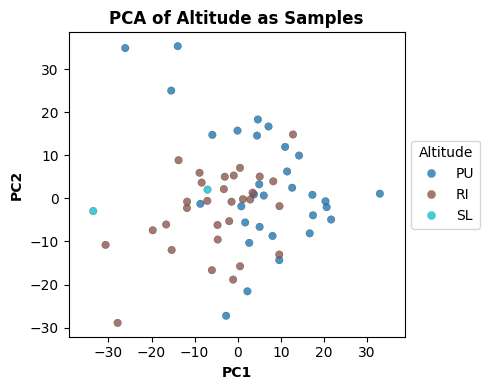

In [12]:
data_df_log_time = data_df_log.join(adata.var['altitude']).reset_index().set_index('altitude').drop('index', axis=1)
pc.principal_component_2d_timesample(data=data_df_log_time, label='Altitude', c_map='tab10')

### Step 5: Identify mean and std threshold values

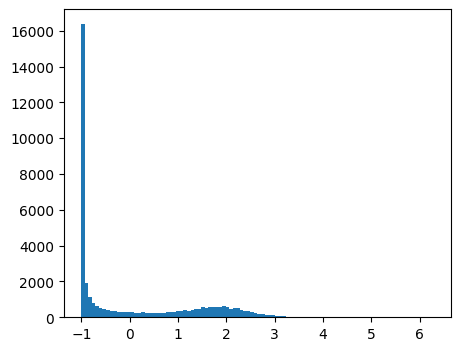

In [13]:
plt.figure(figsize=(5, 4))
plt.hist(x=data_df_log.mean(), bins=100);

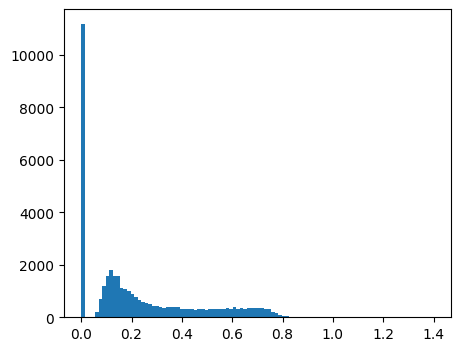

In [14]:
plt.figure(figsize=(5, 4))
plt.hist(x=data_df_log.std(), bins=100);

### Step 5: COFE

### Puno Peru

In [17]:
X_train_a = data_df_log[adata.var['altitude'] == 'PU']
true_time_train_a = adata.var[adata.var['altitude'] == 'PU']['time'].astype(int)

X_train_a, X_test_a, features_a, features_std_a = COFE.analyse.preprocess_data(X_train_a.to_numpy(), None, 
                                                                           features=X_train_a.columns, feature_dim='col', 
                                                                           mean_threshold= 1,scaling_threshold=7)
X_train_a.shape # (Samples, Transcripts)

(31, 5488)

In [18]:
s_choices = np.linspace(1, 50, 15)
cv_a = COFE.analyse.cross_validate(X_train_a, s_choices, features=features_a, K=5, ncores=-1, restarts=10)

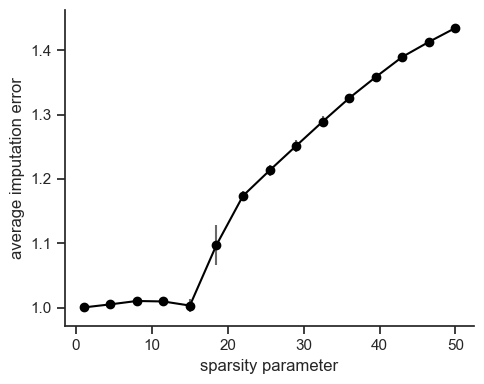

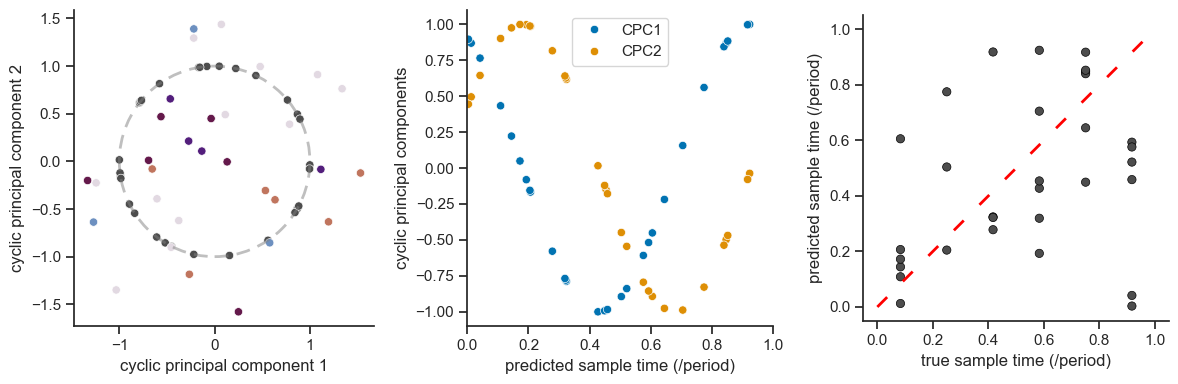

In [19]:
results_train_diet_a = COFE.analyse.predict_time(X_train_a, cv_a, true_times=true_time_train_a.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_a, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_a, time=true_time_train_a.to_numpy(), X=X_train_a, figsize=(12, 4), period=24)

In [20]:
results_train_diet_a["MAPE"]*24

np.float64(3.1092148082328412)

### La Rinconada Peru

In [22]:
X_train_b = data_df_log[adata.var['altitude'] == 'RI']
true_time_train_b = adata.var[adata.var['altitude'] == 'RI']['time'].astype(int)

X_train_b, X_test_b, features_b, features_std_b = COFE.analyse.preprocess_data(X_train_b.to_numpy(), None, 
                                                                           features=X_train_b.columns, feature_dim='col', 
                                                                           mean_threshold= 1,scaling_threshold=8)
X_train_b.shape # (Samples, Transcripts)

(30, 5927)

In [23]:
s_choices = np.linspace(1, 50, 15)
cv_b = COFE.analyse.cross_validate(X_train_b, s_choices, features=features_b, K=5, ncores=-1, restarts=10)

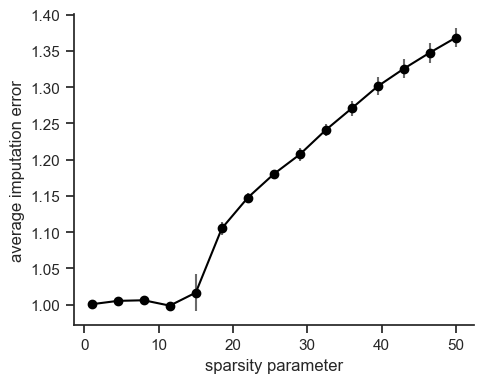

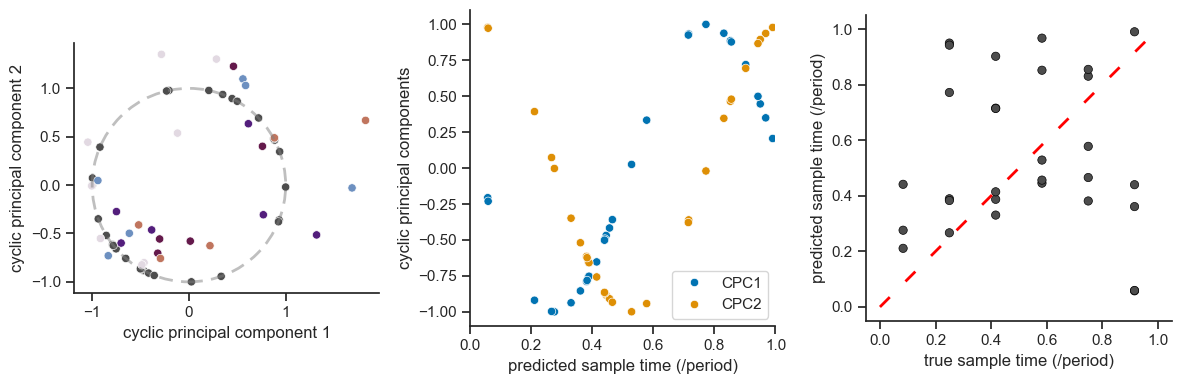

In [24]:
results_train_diet_b = COFE.analyse.predict_time(X_train_b, cv_b, true_times=true_time_train_b.to_numpy(), period=24)
COFE.plot.plot_cv_run(results_train_diet_b, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_b, time=true_time_train_b.to_numpy(), X=X_train_b, figsize=(12, 4), period=24)

In [25]:
results_train_diet_b["MAPE"]*24

np.float64(3.77339400034602)

## Conclusion

So this study confuses me quite a bit because the thing is that blood cells have no nucleus, so the idea for the researchers was to look at everything possible in whole-blood mixture, and looking at PCA there are some differences between seq composition based on altitude. But for doing COFE, which is very sensitive to tissue type, that's obviously a no-go. So in this case, the poor COFE performance is not surprising.